<a href="https://colab.research.google.com/github/anuka0407/Loan-Eligibility-Using-2022-LAR-dataset-HMDA-/blob/main/Thinkful_Final_Project_Loan_Eligibility_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Case Study - Loan Eligibility Prediction**

In this final project, I will work with 2022 loan data published by the Consumer Financial Protection Bureau as their Home Mortgage Disclosure Act (HMDA) reporting requirements in the US.

The HMDA requires certain financial institutions to collect and report data on mortgage loan applications, originations, purchases, and other related activities. The data collected through LAR includes information about the loan applicant, the property, and the loan itself.

Please find the original dataset here:

*Note: Instead of using the large CSV file, I will be utilizing the sampled data available in the "Sampled_data" section for the following analysis. This will allow for faster processing and better resource utilization.*

https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2022


Please find the schema/codebook here:


https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields

**Note that since dataset was too large, I randomly selected 30000 rows from the original csv file & saved it as a new `sampled_data.csv` file.
(I documented random selection of the rows in below code, but since this code runs longer and it selects random rows each time, I will be working with the saved file for this case study moving forward - linked below)**

https://drive.google.com/file/d/1--aJPrP7aMiXQ3ghJ4QlZ8GAeFhY4EUE/view?usp=sharing






## **1.1 Load Required Libraries and Data**

In [48]:
#load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import random
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from scipy import stats


#evaluation metrics and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score
from sklearn import cluster, covariance, manifold


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **PLEASE DO NOT EXECUTE BELOW CODE**


Please note that the code below utilizes a zipfile downloaded from the website (https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2022) for the year 2022. It randomly selects 30,000 rows from the dataset since the file is too large to be loaded in Google Colab.

**Note: Each time the code is executed, it will generate a different random sample.**

For instructors' convenience, they do not need to load the zipfile from the website. Instead, they can use the provided pre-saved CSV file located at the following link: https://drive.google.com/file/d/1--aJPrP7aMiXQ3ghJ4QlZ8GAeFhY4EUE/view?usp=sharing

In the Sampled_data section, the code will work with the pre-saved CSV file to continue the analysis.

This approach ensures that instructors can run the code without having to download the large zipfile and obtain consistent results with the pre-saved CSV file.


In [3]:
## instructor doesnot need to run this code and can move to sampled data section instead

import zipfile

zip_path = '/content/drive/MyDrive/2022_public_lar_csv.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()


In [4]:
# Load the 30k rows to sample from the original CSV file
file_path = '/content/2022_public_lar_csv.csv'
total_rows = sum(1 for _ in open(file_path)) - 1  # Get the total number of rows excluding the header

nrows = 30000
skiprows = sorted(random.sample(range(1, total_rows + 1), total_rows - nrows))  # Randomly select rows to skip

df = pd.read_csv(file_path, skiprows=skiprows)

df.head(5)

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason_2,denial_reason_3,denial_reason_4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,RVDPPPGHCGZ40J4VQ731,24860,SC,45045.0,4.504500e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3291,40.57,80300,111.0,283,595,28
1,2022,RVDPPPGHCGZ40J4VQ731,38060,AZ,4013.0,4.013061e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,6238,36.76,88800,128.0,1273,1724,14
2,2022,RVDPPPGHCGZ40J4VQ731,33124,FL,12086.0,1.208601e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,2594,89.63,68300,214.0,660,791,24
3,2022,RVDPPPGHCGZ40J4VQ731,16984,IL,17031.0,1.703182e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,7753,21.86,105700,103.0,2416,2660,43
4,2022,RVDPPPGHCGZ40J4VQ731,19740,CO,8005.0,8.005083e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Joint,...,NaN,NaN,NaN,6292,45.80,117800,116.0,1541,1690,20


In [5]:
# Save the sampled data as a new CSV file so that each time you load random 30k rows, you do not end up with a new dataset
sampled_file_path = '/content/drive/MyDrive/Thinkful Data Science Projects/Sampled_loan_data.csv'  # i saved the sampled data here
sample_loan_lar=df.to_csv(sampled_file_path, index=False)

print("Sampled data saved successfully.")

Sampled data saved successfully.


## **1.2 Sampled Data**

Dataset: https://drive.google.com/file/d/1--aJPrP7aMiXQ3ghJ4QlZ8GAeFhY4EUE/view?usp=sharing

In [6]:
file_path_1='/content/drive/MyDrive/Thinkful Data Science Projects/Sampled_loan_data.csv'
sampled_data=pd.read_csv(file_path_1)
sampled_data.head(10)

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason_2,denial_reason_3,denial_reason_4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,RVDPPPGHCGZ40J4VQ731,24860,SC,45045.0,4.504500e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3291,40.57,80300,111.0,283,595,28
1,2022,RVDPPPGHCGZ40J4VQ731,38060,AZ,4013.0,4.013061e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,6238,36.76,88800,128.0,1273,1724,14
2,2022,RVDPPPGHCGZ40J4VQ731,33124,FL,12086.0,1.208601e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,2594,89.63,68300,214.0,660,791,24
3,2022,RVDPPPGHCGZ40J4VQ731,16984,IL,17031.0,1.703182e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,7753,21.86,105700,103.0,2416,2660,43
4,2022,RVDPPPGHCGZ40J4VQ731,19740,CO,8005.0,8.005083e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Joint,...,NaN,NaN,NaN,6292,45.80,117800,116.0,1541,1690,20
5,2022,RVDPPPGHCGZ40J4VQ731,26420,TX,48339.0,4.833969e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,8344,43.54,90800,177.0,2624,2736,13
6,2022,RVDPPPGHCGZ40J4VQ731,13820,AL,1073.0,1.073011e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2194,28.94,83300,59.0,549,958,62
7,2022,RVDPPPGHCGZ40J4VQ731,99999,LA,22115.0,2.211595e+10,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3380,39.88,56600,136.0,681,1677,33
8,2022,RVDPPPGHCGZ40J4VQ731,40140,CA,6071.0,6.071000e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,4853,83.89,87400,109.0,1034,1160,59
9,2022,RVDPPPGHCGZ40J4VQ731,38060,AZ,4013.0,4.013092e+09,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,4635,65.20,88800,64.0,620,1035,42


# **2. Data Exploration**

In Predicting Loan Eligibility, my target variable will be ` ACTION TAKEN `, which, as the name suggests is the action taken on the covered loan or application. There are 8 categories listed for this variable:

1 - Loan originated

2 - Application approved but not accepted

3 - Application denied

4 - Application withdrawn by applicant

5 - File closed for incompleteness

6 - Purchased loan

7 - Preapproval request denied

8 - Preapproval request approved but not accepted

------------------------------------------------------------
--------------------------------------------------------------

I will explore each class, but later I might combine different categories to make the variable binary.

 * **Approved** (loan originated, purchased loan, Application approved but not accepted) or
 * **Denied** (Application denied, File closed for incompleteness, Preapproval request denied)

 `For this study purposes, excluded are withdrawn applications and preapprovals approved but not accepted. The analysis focuses on clear loan approval or denial outcomes.`

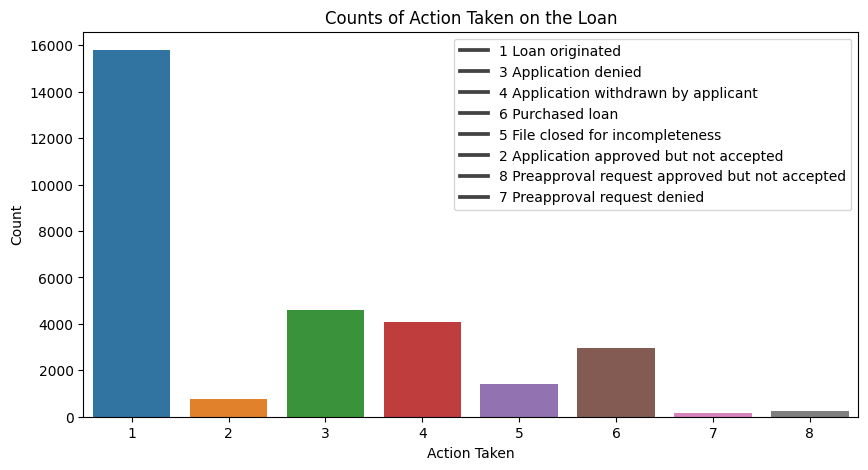

In [7]:
#check value counts for action taken variable

action_taken_counts=sampled_data['action_taken'].value_counts(dropna=False)

plt.figure(figsize=(10,5))

sns.barplot(x=action_taken_counts.index, y=action_taken_counts.values)
# Set the plot labels and title
plt.xlabel('Action Taken')
plt.ylabel('Count')
plt.title('Counts of Action Taken on the Loan')

# Define the action labels for the legend
action_labels = {
    1: 'Loan originated',
    2: 'Application approved but not accepted',
    3: 'Application denied',
    4: 'Application withdrawn by applicant',
    5: 'File closed for incompleteness',
    6: 'Purchased loan',
    7: 'Preapproval request denied',
    8: 'Preapproval request approved but not accepted'
}

# Create the legend
legend_labels = [f'{action} {action_labels[action]}' for action in action_taken_counts.index]
plt.legend(legend_labels, loc='upper right')

# Show the plot
plt.show()


We see that the most loans had been issued (originated and purchased) and the rest were either denied, withdrawn, incomplete.

### **2.1 Feature Selection**

#### **Drop Features with >50% misisng values**

In [8]:
# Select variables with null values
null_variables = sampled_data.columns[sampled_data.isnull().any()]

# Display the variables with null values
print(null_variables)
print(len(null_variables))

Index(['state_code', 'county_code', 'census_tract', 'conforming_loan_limit',
       'combined_loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'total_loan_costs', 'total_points_and_fees', 'origination_charges',
       'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'property_value',
       'multifamily_affordable_units', 'income', 'debt_to_income_ratio',
       'applicant_ethnicity_1', 'applicant_ethnicity_2',
       'applicant_ethnicity_3', 'applicant_ethnicity_4',
       'applicant_ethnicity_5', 'co_applicant_ethnicity_1',
       'co_applicant_ethnicity_2', 'co_applicant_ethnicity_3',
       'co_applicant_ethnicity_4', 'co_applicant_ethnicity_5',
       'applicant_race_1', 'applicant_race_2', 'applicant_race_3',
       'applicant_race_4', 'applicant_race_5', 'co_applicant_race_1',
       'co_applicant_race_2', 'co_applicant_race_3', 'co_applicant_race_4',
       'co_applicant_race_5', 'applicant_age_above_62',
     

In [9]:
#check what variables are missing what fraction of data
missing_fractions = sampled_data.isnull().mean().sort_values(ascending=False)

missing_fractions.head(50)


co_applicant_ethnicity_4             1.000000
applicant_ethnicity_5                1.000000
applicant_ethnicity_4                0.999967
co_applicant_race_5                  0.999967
co_applicant_ethnicity_5             0.999967
co_applicant_race_4                  0.999933
applicant_race_5                     0.999633
denial_reason_4                      0.999533
co_applicant_ethnicity_3             0.999500
applicant_race_4                     0.999367
applicant_ethnicity_3                0.998933
co_applicant_race_3                  0.998600
aus_5                                0.996400
aus_4                                0.996033
applicant_race_3                     0.995233
denial_reason_3                      0.995033
aus_3                                0.985567
co_applicant_race_2                  0.980067
multifamily_affordable_units         0.979267
co_applicant_ethnicity_2             0.979133
total_points_and_fees                0.975767
denial_reason_2                   

In [10]:
drop_list=sorted(list(missing_fractions[missing_fractions>0.5].index))
print(drop_list)
print(len(drop_list))

['applicant_ethnicity_2', 'applicant_ethnicity_3', 'applicant_ethnicity_4', 'applicant_ethnicity_5', 'applicant_race_2', 'applicant_race_3', 'applicant_race_4', 'applicant_race_5', 'aus_2', 'aus_3', 'aus_4', 'aus_5', 'co_applicant_age_above_62', 'co_applicant_ethnicity_2', 'co_applicant_ethnicity_3', 'co_applicant_ethnicity_4', 'co_applicant_ethnicity_5', 'co_applicant_race_2', 'co_applicant_race_3', 'co_applicant_race_4', 'co_applicant_race_5', 'denial_reason_2', 'denial_reason_3', 'denial_reason_4', 'discount_points', 'intro_rate_period', 'lender_credits', 'multifamily_affordable_units', 'origination_charges', 'prepayment_penalty_term', 'total_loan_costs', 'total_points_and_fees']
32


In [11]:
#drop variables in sampled data that are missing more than 50% of observations

sampled_data.drop(labels=drop_list, axis=1, inplace=True)
sampled_data.shape

(30000, 67)

In [12]:
#after dropping variables with more than 50% missing data we are left with 67 columns below
print(sorted(sampled_data.columns))

['action_taken', 'activity_year', 'applicant_age', 'applicant_age_above_62', 'applicant_credit_score_type', 'applicant_ethnicity_1', 'applicant_ethnicity_observed', 'applicant_race_1', 'applicant_race_observed', 'applicant_sex', 'applicant_sex_observed', 'aus_1', 'balloon_payment', 'business_or_commercial_purpose', 'census_tract', 'co_applicant_age', 'co_applicant_credit_score_type', 'co_applicant_ethnicity_1', 'co_applicant_ethnicity_observed', 'co_applicant_race_1', 'co_applicant_race_observed', 'co_applicant_sex', 'co_applicant_sex_observed', 'combined_loan_to_value_ratio', 'conforming_loan_limit', 'construction_method', 'county_code', 'debt_to_income_ratio', 'denial_reason_1', 'derived_dwelling_category', 'derived_ethnicity', 'derived_loan_product_type', 'derived_msa_md', 'derived_race', 'derived_sex', 'ffiec_msa_md_median_family_income', 'hoepa_status', 'income', 'initially_payable_to_institution', 'interest_only_payment', 'interest_rate', 'lei', 'lien_status', 'loan_amount', 'loa

#### **Drop Variables Based on the Intuitiveness**

Based on the method the data was collected, some of the variables reported are duplications (examples are: observed sex and sex of the applicant, applicant_ethnicity_observed & applicant_ethnicity_1 so they are mostly correlated variables and I will remove them from my dataset).

Going over the codebook again, I will select below features that are intuitive based on subjective judgement.

Taking some time to explore Public HDMA- LAR Data Fields linked here https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields, I decided to select below variables for my case study.


- `Loan Amount`: The amount of the covered loan, or the amount applied for
- `Loan Term`: The number of months after which the legal obligation will mature or terminate, or would have matured or terminated.
- `State Code` : Two-letter state code.
- `Income`: The gross annual income, in thousands of dollars, relied on in making the credit decision, or if a credit decision was not made, the gross annual income relied on in processing the application
- `Debt-to-Income Ratio`: The ratio, as a percentage, of the applicant’s or borrower’s total monthly debt to the total monthly income relied on in making the credit decision.< 20%; 20%-<30%; 30%-<36%; 37%, 38%, 39%, 40%, 41%, 42%, 43%, 44%, 45%, 46%, 47%, 48%, 49%, 50%-60%, 60%; NA; Exempt.

- `Action Taken`: The action taken on the covered loan or application -1 - Loan originated; 2 - Application approved but not accepted; 3 - Application denied; 4 - Application withdrawn by applicant; 5 - File closed for incompleteness; 6 - Purchased loan; 7 - Preapproval request denied; 8 - Preapproval request approved but not accepted

- `Purpose of Loan`:  The purpose of covered loan or application; 1 - Home purchase; 2 - Home improvement; 31 - Refinancing; 32 - Cash-out refinancing; 4 - Other purpose; 5 - Not applicable.

- `Combined Loan-to-Value Ratio`: The ratio of the total amount of debt secured by the property to the value of the property relied on in making the credit decision

- `Age`: The age, in years, of the applicant or borrower.< 25;
25-34; 35-44; 45-54; 55-64; 65-74, > 74, 8888.
-
`Applicant_credit_score_type`: 1 - Equifax Beacon 5.0
2 - Experian Fair Isaac
3 - FICO Risk Score Classic 04
4 - FICO Risk Score Classic 98
5 - VantageScore 2.0
6 - VantageScore 3.0
7 - More than one credit scoring model
8 - Other credit scoring model
9 - Not applicable
1111 - Exempt

- `Business or commercial purpose`: Whether the covered loan or application is primarily for a business or commercial purpose: 1 - Primarily for a business or commercial purpose; 2 - Not primarily for a business or commercial purpose; 1111 - Exempt
- `Property value`: The value of the property securing the covered loan or, in the case of an application, proposed to secure the covered loan, relied on in making the credit decision.
- `Occupancy Type`: Occupancy type for the dwelling: 1 - Principal residence; 2 - Second residence; 3 - Investment property
- `Interest Rate`: The interest rate for the covered loan or application.
                                   
-  `Purchaser_type`:  Type of entity purchasing a covered loan from the institution, 0 - Not applicable; 1 - Fannie Mae; 2 - Ginnie Mae; 3 - Freddie Mac; 4 - Farmer Mac; 5 - Private securitizer; 6 - Commercial bank, savings bank, or savings association; 71 - Credit union, mortgage company, or finance company; 72 - Life insurance company; 8 - Affiliate institution; 9 - Other type of purchaser
-  `Preapproval`: Whether the covered loan or application involved a request for a preapproval of a home purchase loan under a preapproval program - 1 Yes, 2 no
- `Loan_type`: The type of covered loan or application, 1 - Conventional (not insured or guaranteed by FHA, VA, RHS, or FSA); 2 - Federal Housing Administration insured (FHA); 3 - Veterans Affairs guaranteed (VA); 4 - USDA Rural Housing Service or Farm Service Agency guaranteed (RHS or FSA)                        
- `Lien_status`- Lien status of the property securing the covered loan, or in the case of an application, proposed to secure the covered loan- 1 - Secured by a first lien; 2 - Secured by a subordinate lien                     
-  `Hoepa_status`: Whether the covered loan is a high-cost mortgage - 1 - High-cost mortgage; 2 - Not a high-cost mortgage; 3 - Not applicable
-  `Negative_amortization`: Whether the contractual terms include, or would have included, a term that would cause the covered loan to be a negative amortization loan; 1 - Negative amortization; 2 - No negative amortization; 1111 - Exempt             
- `Balloon_payment`: Whether the contractual terms include, or would have included, a balloon payment - 1 - Balloon payment; 2 - No balloon payment; 1111 - Exempt
-  `Co_applicant_credit_score_type`: The name and version of the credit scoring model used to generate the credit score, or scores, relied on in making the credit decision -1 - Equifax Beacon 5.0; 2 - Experian Fair Isaac; 3 - FICO Risk Score Classic 04; 4 - FICO Risk Score Classic 98; 5 - VantageScore 2.0; 6 - VantageScore 3.0; 7 - More than one credit scoring model; 8 - Other credit scoring model; 9 - Not applicable; 10 - No co-applicant; 1111 - Exempt
- `Applicant_race` 1 - American Indian or Alaska Native; 2 - Asian; 21 - Asian Indian; 22 - Chinese; 23 - Filipino; 24 - Japanese; 25 - Korean; 26 - Vietnamese
27 - Other Asian; 3 - Black or African American; 4 - Native Hawaiian or Other Pacific Islander; 41 - Native Hawaiian; 42 - Guamanian or Chamorro; 43 - Samoan; 44 - Other Pacific Islander; 5 - White; 6 - Information not provided by applicant in mail, internet, or telephone application; 7 - Not applicable
- `tract_one_to_four_family_homes` - Dwellings that are built to houses with fewer than 5 families       
- `tract_owner_occupied_units` - Number of dwellings, including individual condominiums, that are lived in by the owner
- `Applicant_sex`: 1 - Male; 2 - Female; 3 - Information not provided by applicant in mail, internet, or telephone application; 4 - Not applicable
6 - Applicant selected both male and female
- `Ffiec_msa_md_median_family_income`  FFIEC Median family income in dollars for the MSA/MD in which the tract is located (adjusted annually by FFIEC)
 25  


In [13]:
keep_list=['action_taken', 'applicant_age', 'applicant_race_1', 'applicant_sex', 'applicant_credit_score_type', 'balloon_payment', 'business_or_commercial_purpose',
            'co_applicant_credit_score_type', 'combined_loan_to_value_ratio', 'debt_to_income_ratio', 'ffiec_msa_md_median_family_income', 'hoepa_status', 'income',
            'loan_amount', 'loan_purpose', 'loan_term', 'interest_rate', 'loan_type','lien_status', 'state_code', 'negative_amortization', 'preapproval', 'purchaser_type', 'property_value', 'occupancy_type', 'tract_one_to_four_family_homes', 'tract_owner_occupied_units']

len(keep_list)

27

In [15]:
drop_list_selected = [col for col in sampled_data.columns if col not in keep_list]

sampled_data.drop(labels=drop_list_selected, axis=1, inplace=True)

sampled_data.shape

(30000, 27)

From the selected variables and inspecting the codebook, we see that there are **9 continuous variables** and **18 categorical variables** which are already encoded (I will need to correct the encoding for some of those variables but for now I will explore correlation between `loan action` and continuous variables using Pearson correlation coefficient & `loan action` and encoded categorical variables using Chi square & Cramer's V association.

In [16]:
# note that some of the numeric variables are labeled as object ( the reason is EXEMPT value included in variables
## based on codebook definiotions.
## I will do data cleaning for numeric and cat variables in next section.)
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   state_code                         29644 non-null  object 
 1   action_taken                       30000 non-null  int64  
 2   purchaser_type                     30000 non-null  int64  
 3   preapproval                        30000 non-null  int64  
 4   loan_type                          30000 non-null  int64  
 5   loan_purpose                       30000 non-null  int64  
 6   lien_status                        30000 non-null  int64  
 7   business_or_commercial_purpose     30000 non-null  int64  
 8   loan_amount                        30000 non-null  int64  
 9   combined_loan_to_value_ratio       20195 non-null  object 
 10  interest_rate                      19773 non-null  object 
 11  hoepa_status                       30000 non-null  int

#### **Drop Features based on the correlation**

Now I will do some data wrangling for both numeric and categorical variables and will drop variables based on correlation if required.

##### **Numeric Variables**

Based on the codebook decsriptions, actual numeric variables (which are not already encoded) are:



1. `loan_term`
2. `income`
3. `combined_loan_to_value_ratio`
4. `property_value`
5. `interest_rate`
6. `ffiec_msa_md_median_family_income`
7. `loan_amount`
8. `tract_owner_occupied_units`
9. `tract_one_to_four_family_homes`


*Note: They appear as object since some rows within the columns have EXEMPT or E as a provided value.*


In [17]:
#encode Action_taken as binary moving forward for this analysis

def action(value):
  if value in [1, 2, 6]:
   return 1
  elif value in [3, 5, 7]:
   return 2
  else:
    return None

sampled_data['action_taken']=sampled_data['action_taken'].apply(action)

## as I mentioned in the beginning of  Data Exploration section,
# For this study purposes, when applicant withdraws the application or preapproval request is approved but not accepted, do not indicate approval or denial of the actual loan application
# So I will drop the observations that had those action status


# Drop rows with NaN values in the 'action_taken' column
sampled_data.dropna(subset=['action_taken'], inplace=True)

In [ ]:
#freq of each outcome
sampled_data['action_taken'].value_counts()

1.0    19227
2.0     6368
Name: action_taken, dtype: int64

In [18]:
#convert to numeric below 4 variables that appeared as objects instead of num
sampled_data['loan_term']=pd.to_numeric(sampled_data['loan_term'], errors='coerce')
sampled_data['combined_loan_to_value_ratio']=pd.to_numeric(sampled_data['combined_loan_to_value_ratio'], errors='coerce')
sampled_data['property_value']=pd.to_numeric(sampled_data['property_value'], errors='coerce')
sampled_data['interest_rate']=pd.to_numeric(sampled_data['interest_rate'], errors='coerce')

#fill NaN values with mean values
sampled_data['loan_term'].fillna(sampled_data['loan_term'].mean(), inplace=True)
sampled_data['combined_loan_to_value_ratio'].fillna(sampled_data['combined_loan_to_value_ratio'].mean(), inplace=True)
sampled_data['property_value'].fillna(sampled_data['property_value'].mean(), inplace=True)
sampled_data['interest_rate'].fillna(sampled_data['interest_rate'].mean(), inplace=True)

#fill missing values of income with mean
sampled_data['income'].fillna(sampled_data['income'].mean(), inplace=True)

sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25664 entries, 1 to 29998
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   state_code                         25495 non-null  object 
 1   action_taken                       25664 non-null  float64
 2   purchaser_type                     25664 non-null  int64  
 3   preapproval                        25664 non-null  int64  
 4   loan_type                          25664 non-null  int64  
 5   loan_purpose                       25664 non-null  int64  
 6   lien_status                        25664 non-null  int64  
 7   business_or_commercial_purpose     25664 non-null  int64  
 8   loan_amount                        25664 non-null  int64  
 9   combined_loan_to_value_ratio       25664 non-null  float64
 10  interest_rate                      25664 non-null  float64
 11  hoepa_status                       25664 non-null  int

In [25]:
#filter action_taken( target var) &  actual numerical variables based on the codebook for pearson coefficient
numeric_df=sampled_data[['action_taken', 'loan_term', 'income', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'ffiec_msa_md_median_family_income', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']]


rounded_num_df = numeric_df.round(5)
print(rounded_num_df.describe())
numeric_df.info()



       action_taken     loan_term         income  \
count  25664.000000  25664.000000   25664.000000   
mean       1.239285    322.328006     163.159812   
std        0.426655     79.408086    2416.618036   
min        1.000000      1.000000   -1116.000000   
25%        1.000000    322.328010      65.000000   
50%        1.000000    360.000000     108.000000   
75%        1.000000    360.000000     163.159810   
max        2.000000    600.000000  363000.000000   

       combined_loan_to_value_ratio  property_value  interest_rate  \
count                  25664.000000    2.566400e+04   25664.000000   
mean                      89.194634    5.442511e+05       4.791283   
std                     1872.424143    2.058264e+06       1.330121   
min                        0.018290    5.000000e+03       0.000000   
25%                       68.453750    2.550000e+05       4.000000   
50%                       82.088500    4.050000e+05       4.791280   
75%                       89.194630    5.

I see that most of my numeric variables are suffering from extreme outliers. I will try to use *winsorization technique at 95 %ile* for variables and log transform income, since it contains negative values.

In [36]:
#winsorize : loan term, combined loan to value ratios, property value, capping at 90%

winsorized_cols=['loan_term', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']

for col in winsorized_cols:
  sampled_data[col]=winsorize(sampled_data[col], limits=(0, 0.05), inplace=True)

print(sampled_data[['loan_term', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']].describe())

#log transform income ( it has some negative values)
sampled_data['income']=np.log1p(sampled_data['income']) ## np.log1p() computes the natural logarithm of the 'income' column after adding 1 to each value. The function handles negative values by transforming them appropriately.
#nan values are returned for neg values so I ll have to fill them again with mean

sampled_data['income'].fillna(sampled_data['income'].mean(), inplace=True)

#check outcomes
print(sampled_data[['loan_term', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'income']].describe())


          loan_term  combined_loan_to_value_ratio  property_value  \
count  25664.000000                  25664.000000    25664.000000   
mean     320.564991                     76.834300   436458.863167   
std       77.226831                     19.357767   223535.638432   
min        1.000000                      0.018290     5000.000000   
25%      322.328006                     68.453750   255000.000000   
50%      360.000000                     82.088500   405000.000000   
75%      360.000000                     89.194635   545000.000000   
max      360.000000                     96.500000   855000.000000   

       interest_rate    loan_amount  tract_owner_occupied_units  \
count   25664.000000   25664.000000                25664.000000   
mean        4.685552  249540.991272                 1178.393937   
std         1.088160  159996.419036                  495.494599   
min         0.000000    5000.000000                    0.000000   
25%         4.000000  115000.000000        

In [38]:
#### NOW AGAIN select numeric variables from sampled data that is cleaner.
#filter action_taken( target var) &  actual numerical variables based on the codebook for pearson coefficient
numeric_df_clean=sampled_data[['action_taken', 'loan_term', 'income', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'ffiec_msa_md_median_family_income', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']]


rounded_num_df_clean = numeric_df_clean.round(5)
print(rounded_num_df_clean.describe())
numeric_df_clean.info()


       action_taken     loan_term        income  combined_loan_to_value_ratio  \
count  25664.000000  25664.000000  25664.000000                  25664.000000   
mean       1.239285    320.564992      1.717293                     76.834298   
std        0.426655     77.226831      0.183159                     19.357766   
min        1.000000      1.000000      0.000000                      0.018290   
25%        1.000000    322.328010      1.649560                     68.453750   
50%        1.000000    360.000000      1.738950                     82.088500   
75%        1.000000    360.000000      1.808430                     89.194630   
max        2.000000    360.000000      2.624830                     96.500000   

       property_value  interest_rate  ffiec_msa_md_median_family_income  \
count    25664.000000   25664.000000                       25664.000000   
mean    436458.863167       4.685551                       92016.665368   
std     223535.638432       1.088160         

In [39]:
corr=numeric_df_clean.corr()

num_corr_actiontaken=abs(corr['action_taken'])

In [40]:
num_corr_actiontaken.sort_values(ascending=False).round(5)

action_taken                         1.00000
income                               0.19970
loan_amount                          0.18692
ffiec_msa_md_median_family_income    0.09032
tract_owner_occupied_units           0.08911
tract_one_to_four_family_homes       0.06801
interest_rate                        0.05450
loan_term                            0.03135
combined_loan_to_value_ratio         0.00949
property_value                       0.00100
Name: action_taken, dtype: float64

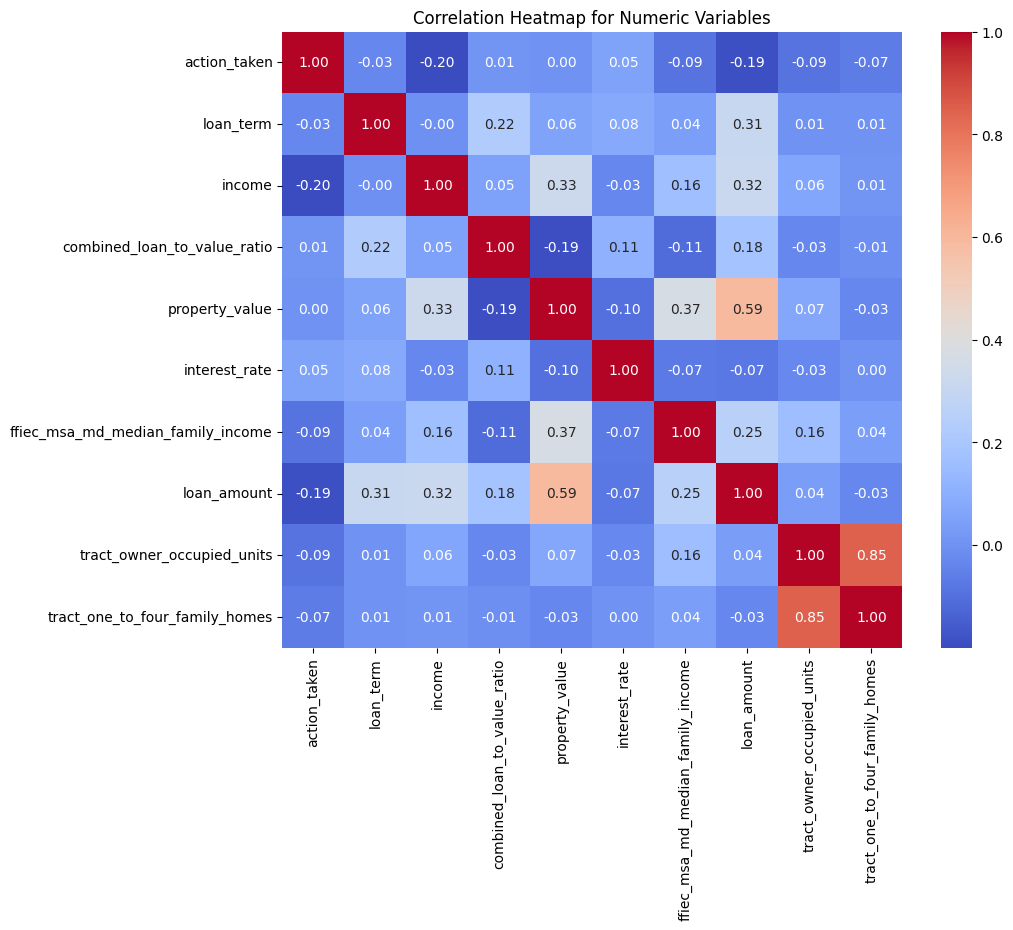

In [41]:
#visualize
plt.figure(figsize=(10, 8))
sns.heatmap(corr,  annot=True, cmap='coolwarm', fmt='.2f')


plt.title('Correlation Heatmap for Numeric Variables')
plt.show()

In [42]:
# I won't drop those variables in the end even though correlation is almost non-existant
drop_list_corr = sorted(list(num_corr_actiontaken[num_corr_actiontaken < 0.02].index))
print(drop_list_corr)

['combined_loan_to_value_ratio', 'property_value']


Surprisingly, the variables I would anticipate to have higher correlation to action taken such as combined_loan_to_value_ratio and property value are at the very bottom of the list. However I decided to keep those variables in my models to further evaluate their importance.

#####  **Categorical Variables Encoding**

Remaining 18 variables are encoded categorical features:

 1.   `action_taken`

 2.   `purchaser_type`                   
 3.  `preapproval`                       
 4.   `loan_type`                         
 5.   `loan_purpose`                     
 6.   `lien_status`                     
 7.   `business_or_commercial_purpose`   
 8.   `hoepa_status`                    
 9.   `negative_amortization`             
 10.  `balloon_payment`                  
 11.  `occupancy_type`                  
 12.  `debt_to_income_ratio`           
 13.  `co_applicant_credit_score_type`  
 14.  `applicant_race_1 `               
 15.  `applicant_sex `                  
 16.  `applicant_age`  
 17.  `state_code `
 18. `applicant_credit_score_type`



Based on the codebook information & descriptions, i want to explore and encode below variables more intuitively.

- **business_or_commercial_purpose**

- **negative_amortization**

- **balloon_payment**

- **co_applicant_credit_score_type**

- **applicant_age**

- **debt_to_income_ratio**  

- **state_code**    

In [43]:
# encode debt to income ratio & for ranges provide one value which is midpoint of the range
import statistics as stats

def convert(value):
  if value == '<20%':
    return 20
  elif value == '20%-<30%':
    return 25
  elif value == '30%-<36%':
    return 33
  elif value == '50%-60%':
    return 55
  elif value == '>60%':
    return 65
  elif value in ['NA', 'Exempt', 'E']:
   return None
  else:
    return value

sampled_data['debt_to_income_ratio']=sampled_data['debt_to_income_ratio'].apply(convert)


In [44]:
#check outcomes
print(sampled_data.debt_to_income_ratio.value_counts())

#fill missing values for debt to income with the mode
sampled_data['debt_to_income_ratio'].fillna(sampled_data['debt_to_income_ratio'].mode()[0], inplace=True)

sampled_data['debt_to_income_ratio']=pd.to_numeric(sampled_data['debt_to_income_ratio'])

25    3188
33    3057
55    1633
20    1436
65    1281
44     840
42     777
49     750
41     736
43     736
39     689
38     658
40     644
37     597
45     580
48     560
36     538
46     507
47     441
Name: debt_to_income_ratio, dtype: int64


In [45]:
#encode age category more intuitively, use the max value for the provided age range

def age_bins(x):
  if x == '<25':
    return 24
  elif x == '25-34':
    return 34
  elif x=='35-44':
    return 44
  elif x=='45-54':
    return 54
  elif x=='55-64':
    return 64
  elif x=='65-74':
    return 74
  elif x=='>74':
    return 75
  else:
    return None


#apply function to applicant age
sampled_data['applicant_age']=sampled_data['applicant_age'].apply(age_bins)

#fill in NAN values with mode
sampled_data['applicant_age'].fillna(sampled_data['applicant_age'].mode()[0], inplace=True)



In [46]:
#check outcomes
sampled_data['applicant_age'].value_counts()

44.0    8756
54.0    5044
34.0    4392
64.0    3853
74.0    2072
75.0     808
24.0     739
Name: applicant_age, dtype: int64

In [47]:
# fill na values with state code

sampled_data['state_code'].fillna(sampled_data['state_code'].mode()[0], inplace=True)
sampled_data['applicant_race_1'].fillna(sampled_data['applicant_race_1'].mode()[0], inplace=True)

In [ ]:
#explore variables that have 1111-Exempt as their values and fill with the mode
sampled_data['business_or_commercial_purpose'].value_counts()


2       23880
1        1204
1111      511
Name: business_or_commercial_purpose, dtype: int64

In [53]:
sampled_data['business_or_commercial_purpose'].replace(to_replace=1111, value=stats.mode(sampled_data['business_or_commercial_purpose']).mode[0], inplace=True)

sampled_data['negative_amortization'].replace(to_replace=1111, value=stats.mode(sampled_data['negative_amortization']).mode[0], inplace=True)

sampled_data['balloon_payment'].replace(to_replace=1111, value=stats.mode(sampled_data['balloon_payment']).mode[0], inplace=True)

sampled_data['co_applicant_credit_score_type'].replace(to_replace=[1111, 9], value=stats.mode(sampled_data['co_applicant_credit_score_type']).mode[0], inplace=True)

sampled_data['applicant_credit_score_type'].replace(to_replace=[1111, 9], value=stats.mode(sampled_data['applicant_credit_score_type']).mode[0], inplace=True)


<ipython-input-53-3a51f458423e>:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  sampled_data['business_or_commercial_purpose'].replace(to_replace=1111, value=stats.mode(sampled_data['business_or_commercial_purpose']).mode[0], inplace=True)
<ipython-input-53-3a51f458423e>:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted.

In [57]:
sampled_data['co_applicant_credit_score_type'].value_counts()

10    21384
1      1150
2      1121
3      1036
8       515
11      196
7       192
6        43
4        21
5         6
Name: co_applicant_credit_score_type, dtype: int64

In [58]:
#create a new variable from co applicant credit score type - whether there was a co applicant or no

def co_applicant(value):
  if value in [1, 2, 3, 4, 5, 6, 7, 8]:
    return 1
  else:
    return 0

sampled_data['has_coapplicant']=sampled_data['co_applicant_credit_score_type'].apply(co_applicant)

In [59]:
#explore now only encoded categorical variables

drop_cols=sampled_data[['loan_term', 'income', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'ffiec_msa_md_median_family_income', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']]
cat_df = sampled_data.drop(columns=drop_cols)
print(cat_df.info())
print(cat_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25664 entries, 1 to 29998
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   state_code                      25664 non-null  object 
 1   action_taken                    25664 non-null  float64
 2   purchaser_type                  25664 non-null  int64  
 3   preapproval                     25664 non-null  int64  
 4   loan_type                       25664 non-null  int64  
 5   loan_purpose                    25664 non-null  int64  
 6   lien_status                     25664 non-null  int64  
 7   business_or_commercial_purpose  25664 non-null  int64  
 8   hoepa_status                    25664 non-null  int64  
 9   negative_amortization           25664 non-null  int64  
 10  balloon_payment                 25664 non-null  int64  
 11  occupancy_type                  25664 non-null  int64  
 12  debt_to_income_ratio            

**Correlation coefficient between categorical variables using Chi-square test of independence**


 **Chi-squared statistic**
 - Chi-Square statistic meausres the discrepency between the observed frequencies and the expected frequencies in a contingency table.
 - Larger values of the chi-square statisc indicate a greater discrepency or a stronger association between the variables.


**P-value**
 - The p-value represents the probability of obtaining the observed data (or data more extreme) if the null hypothesis is true.
 - A smaller p-value suggests stronger evidence against the null hypothesis, indicating a significant association between the variables.

In [60]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")


#categorical variable assoac
from scipy.stats import chi2_contingency

# Create an empty Df to store the chi-square test results
association_results = pd.DataFrame(columns=['Variable1', 'Variable2', 'Chi2', 'P-value'])

# target var
variable1 = 'action_taken'

# Iterate through the remaining variables
for variable2 in cat_df.columns:
    if variable2 != variable1:
        # Create a contingency table
        contingency_table = pd.crosstab(cat_df[variable1], cat_df[variable2])

        # Perform the chi-square test of independence
        chi2, p_value, _, _ = chi2_contingency(contingency_table)

        # Append the results to the association_results DataFrame
        association_results = association_results.append({'Variable1': variable1, 'Variable2': variable2, 'Chi2': chi2.round(5), 'P-value': p_value.round(5)}, ignore_index=True)

# Print the association results
association_results


,Variable1,Variable2,Chi2,P-value
0,action_taken,state_code,255.07891,0.00000
1,action_taken,purchaser_type,6503.91038,0.00000
2,action_taken,preapproval,0.21561,0.64241
3,action_taken,loan_type,45.02113,0.00000
4,action_taken,loan_purpose,1445.24464,0.00000
5,action_taken,lien_status,477.17972,0.00000
6,action_taken,business_or_commercial_purpose,29.64077,0.00000
7,action_taken,hoepa_status,15117.04419,0.00000
8,action_taken,negative_amortization,2.49852,0.11395
9,action_taken,balloon_payment,17.21475,0.00003


P Values are significantly small for all the variables, except negative amortization & preapproval requested. Small P-values (< alpha=0.05) indicate a strong association between action taken and other categorical variables.

**After cleaning both Numerical and Categorical variables and exploring the correlation/association between target (action_taken) and remaining features, I decided to keep all 27 variables + action taken (target var) for my model building.**

## **2.2 Visualizations of some variables**

In [63]:
sampled_data.head(10)
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25664 entries, 1 to 29998
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   state_code                         25664 non-null  object 
 1   action_taken                       25664 non-null  float64
 2   purchaser_type                     25664 non-null  int64  
 3   preapproval                        25664 non-null  int64  
 4   loan_type                          25664 non-null  int64  
 5   loan_purpose                       25664 non-null  int64  
 6   lien_status                        25664 non-null  int64  
 7   business_or_commercial_purpose     25664 non-null  int64  
 8   loan_amount                        25664 non-null  int64  
 9   combined_loan_to_value_ratio       25664 non-null  float64
 10  interest_rate                      25664 non-null  float64
 11  hoepa_status                       25664 non-null  int

##### **Visualize Numerical Variables**

loan_term
income
combined_loan_to_value_ratio
property_value
interest_rate
ffiec_msa_md_median_family_income
loan_amount

> **`Feature: Income`**

         income
count  25664.00
mean       1.72
std        0.18
min        0.00
25%        1.65
50%        1.74
75%        1.81
max        2.62


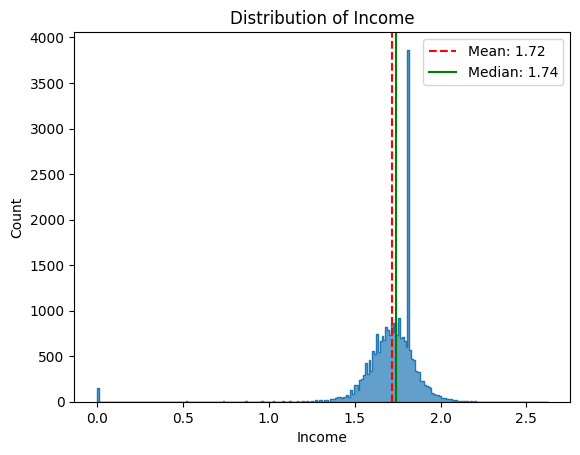

In [69]:
#explore income

print(sampled_data[['income']].describe().round(2))

#visualize
sns.histplot(sampled_data['income'], alpha=0.7, element='step')

# Calculate the mean & median
mean_income = sampled_data['income'].mean()
median_income=sampled_data['income'].median()

# Add a red line at the mean value & green to median
plt.axvline(x=mean_income, color='red', linestyle='--', label=f"Mean: {mean_income:.2f}")
plt.axvline(x=median_income, color='g', label=f"Median: {median_income:.2f}")


plt.title("Distribution of Income")
plt.xlabel("Income")
plt.legend()
plt.show()

> **`Feature: property_value`**

       property_value
count         25664.0
mean         436459.0
std          223536.0
min            5000.0
25%          255000.0
50%          405000.0
75%          545000.0
max          855000.0


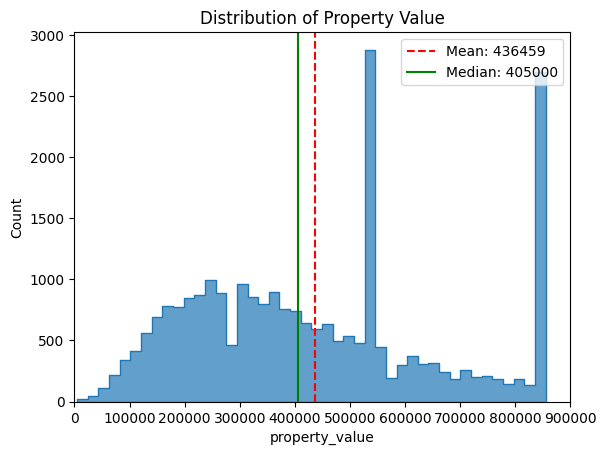

In [70]:
print(sampled_data[['property_value']].describe().round(0))


#visualize

sns.histplot(sampled_data['property_value'], alpha=0.7, element='step')
plt.xlim(0, 900000)
plt.title("Distribution of Property Value")

mean_pvalue=sampled_data['property_value'].mean()
median_pvalue=sampled_data['property_value'].median()

plt.axvline(x=mean_pvalue, color='r', linestyle='--', label=f"Mean: {mean_pvalue:.0f}")
plt.axvline(x=median_pvalue, color='g', label=f"Median: {median_pvalue:.0f}")

plt.legend()
plt.show()


> **`Feature: interest_rate`**

       interest_rate
count      25664.000
mean           4.686
std            1.088
min            0.000
25%            4.000
50%            4.791
75%            5.375
max            6.375


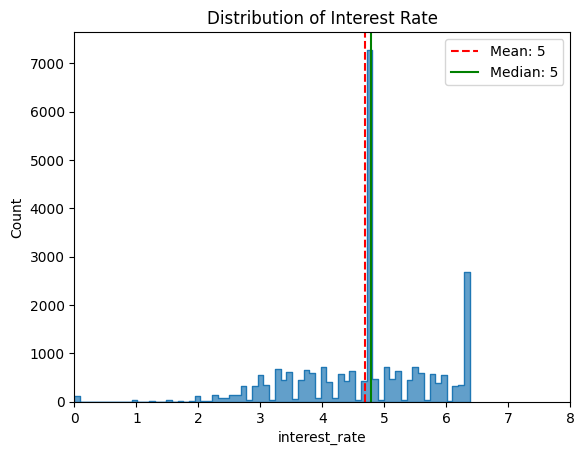

In [71]:
print(sampled_data[['interest_rate']].describe().round(3))


#visualize

sns.histplot(sampled_data['interest_rate'], alpha=0.7, element='step')
plt.xlim(0, 8)
plt.title("Distribution of Interest Rate")

mean_intvalue=sampled_data['interest_rate'].mean()
median_intvalue=sampled_data['interest_rate'].median()

plt.axvline(x=mean_intvalue, color='r', linestyle='--', label=f"Mean: {mean_intvalue:.0f}")
plt.axvline(x=median_intvalue, color='g', label=f"Median: {median_intvalue:.0f}")

plt.legend()
plt.show()


> **`Feature: ffiec_msa_md_median_family_income`**

       ffiec_msa_md_median_family_income
count                            25664.0
mean                             92017.0
std                              22630.0
min                                  0.0
25%                              80100.0
50%                              90800.0
75%                             102200.0
max                             168300.0


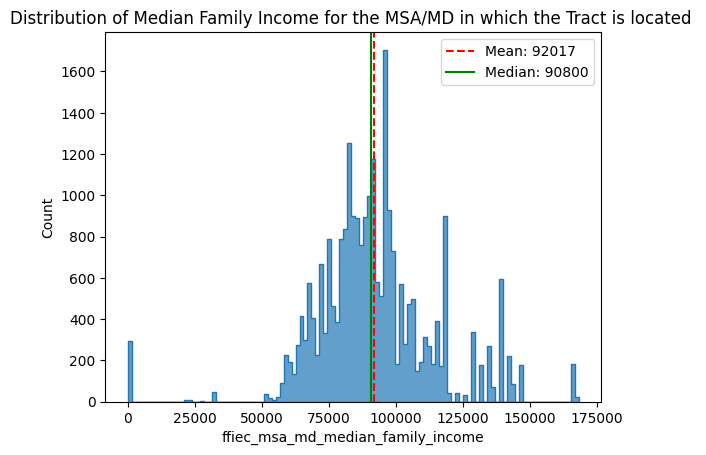

In [72]:
print(sampled_data[['ffiec_msa_md_median_family_income']].describe().round(0))


#visualize

sns.histplot(sampled_data['ffiec_msa_md_median_family_income'], alpha=0.7, element='step')
plt.title("Distribution of Median Family Income for the MSA/MD in which the Tract is located ")

mean_ffivalue=sampled_data['ffiec_msa_md_median_family_income'].mean()
median_ffivalue=sampled_data['ffiec_msa_md_median_family_income'].median()

plt.axvline(x=mean_ffivalue, color='r', linestyle='--', label=f"Mean: {mean_ffivalue:.0f}")
plt.axvline(x=median_ffivalue, color='g', label=f"Median: {median_ffivalue:.0f}")

plt.legend()
plt.show()

##### **Visualize Some Categorical Variables**

> **`Feature: Preapproval Requested`**

Number of individuals with preapproval who were accepted for a loan: 464
Percentage of individuals with preapproval who were accepted for a loan: 1.8079800498753118


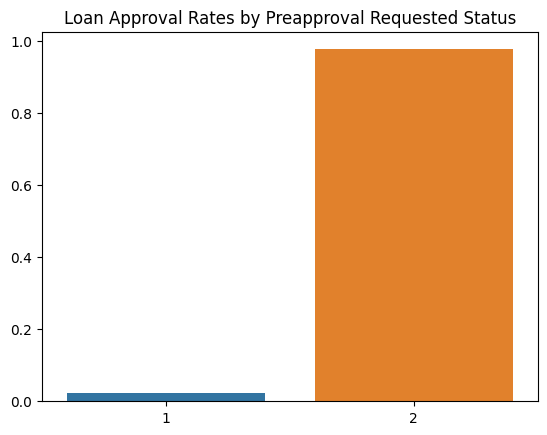

In [73]:
# Filter the DataFrame for rows with preapproval and action_taken as 'accepted'
preapproval_accepted = sampled_data[(sampled_data['preapproval'] == 1) & (sampled_data['action_taken'] == 1)]

# Calculate the count and percentage of preapproval accepted loans
preapproval_accepted_count = len(preapproval_accepted)
preapproval_accepted_percentage = preapproval_accepted_count / len(sampled_data) * 100

# Display the count and percentage
print("Number of individuals with preapproval who were accepted for a loan:", preapproval_accepted_count)
print("Percentage of individuals with preapproval who were accepted for a loan:", preapproval_accepted_percentage)

# Plot the bar graph of preapproval rates
preapproval_rates = sampled_data['preapproval'].value_counts(normalize=True)
sns.barplot(x=preapproval_rates.index, y=preapproval_rates.values)


plt.title("Loan Approval Rates by Preapproval Requested Status")
plt.show()

> **`Feature: State`**

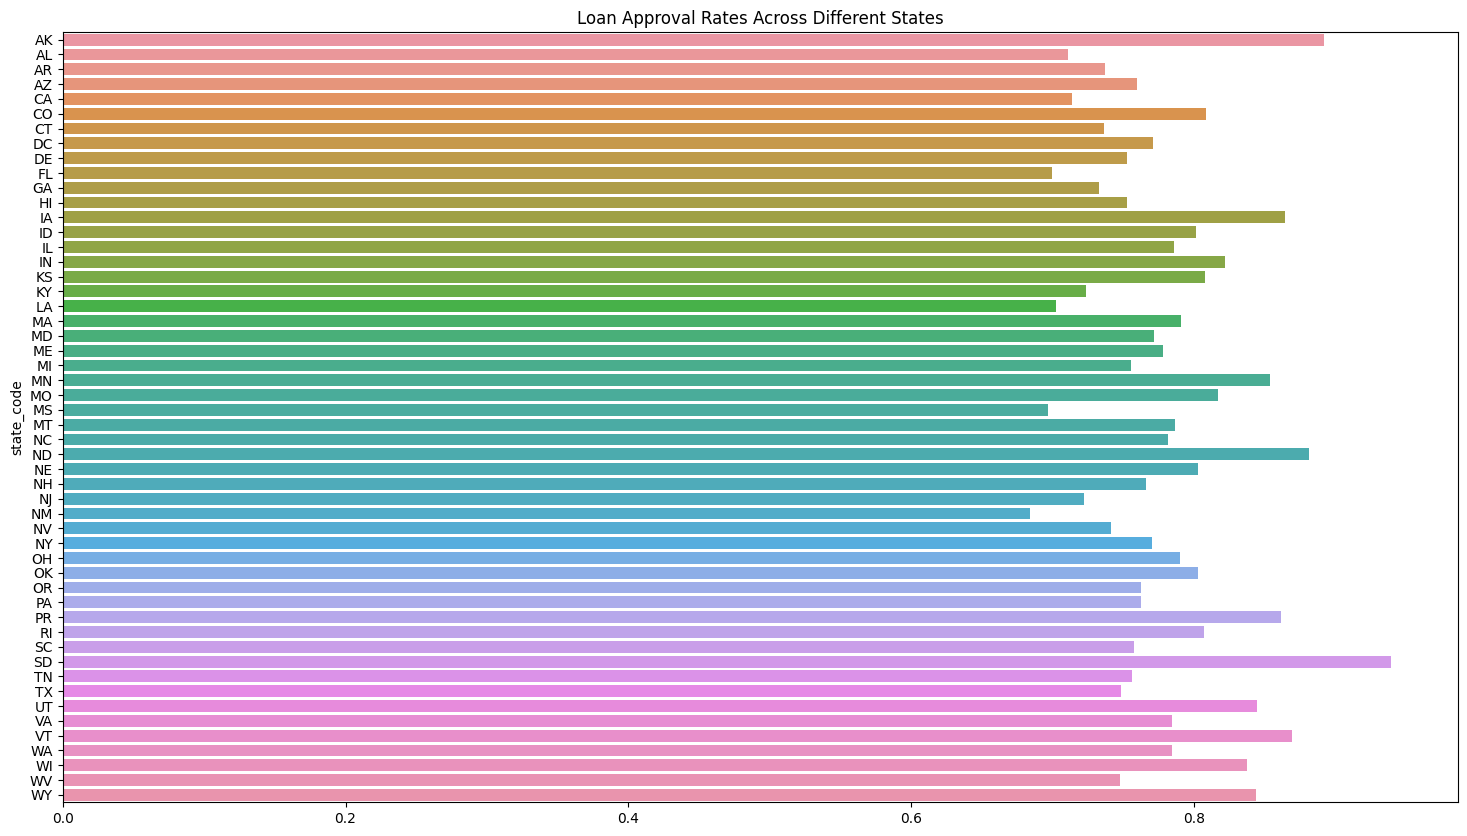

In [74]:
statecode_rates = sampled_data.groupby('state_code')['action_taken'].value_counts(normalize=True).loc[:,1]

plt.figure(figsize=(18,10))
sns.barplot(x=statecode_rates.values, y=statecode_rates.index, orient='h')

plt.title("Loan Approval Rates Across Different States")
plt.show()


> **`Feature: debt_to_income_ratio`**



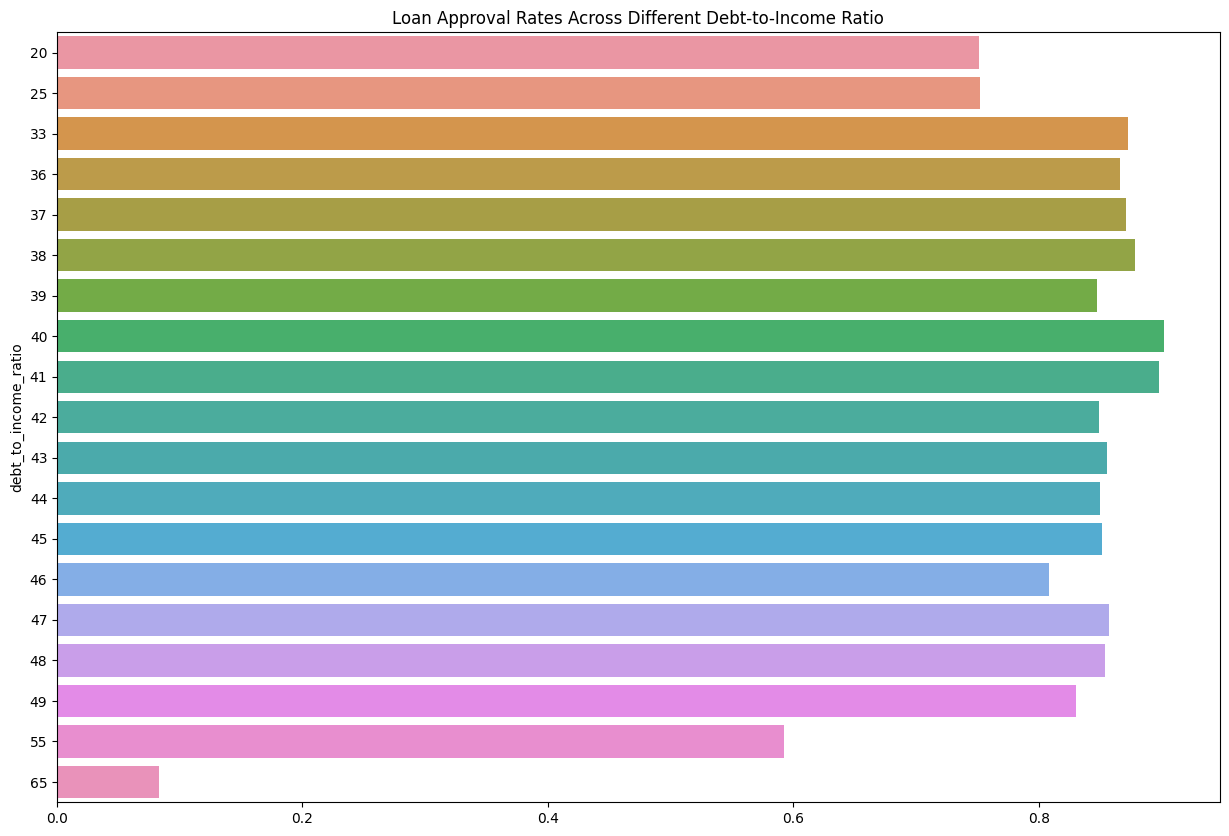

In [75]:
debt_to_income_rates = sampled_data.groupby('debt_to_income_ratio')['action_taken'].value_counts(normalize=True).loc[:,1]

plt.figure(figsize=(15,10))
sns.barplot(x=debt_to_income_rates.values, y=debt_to_income_rates.index, orient='h')

plt.title("Loan Approval Rates Across Different Debt-to-Income Ratio")
plt.show()

> **`Feature: loan_purpose`**




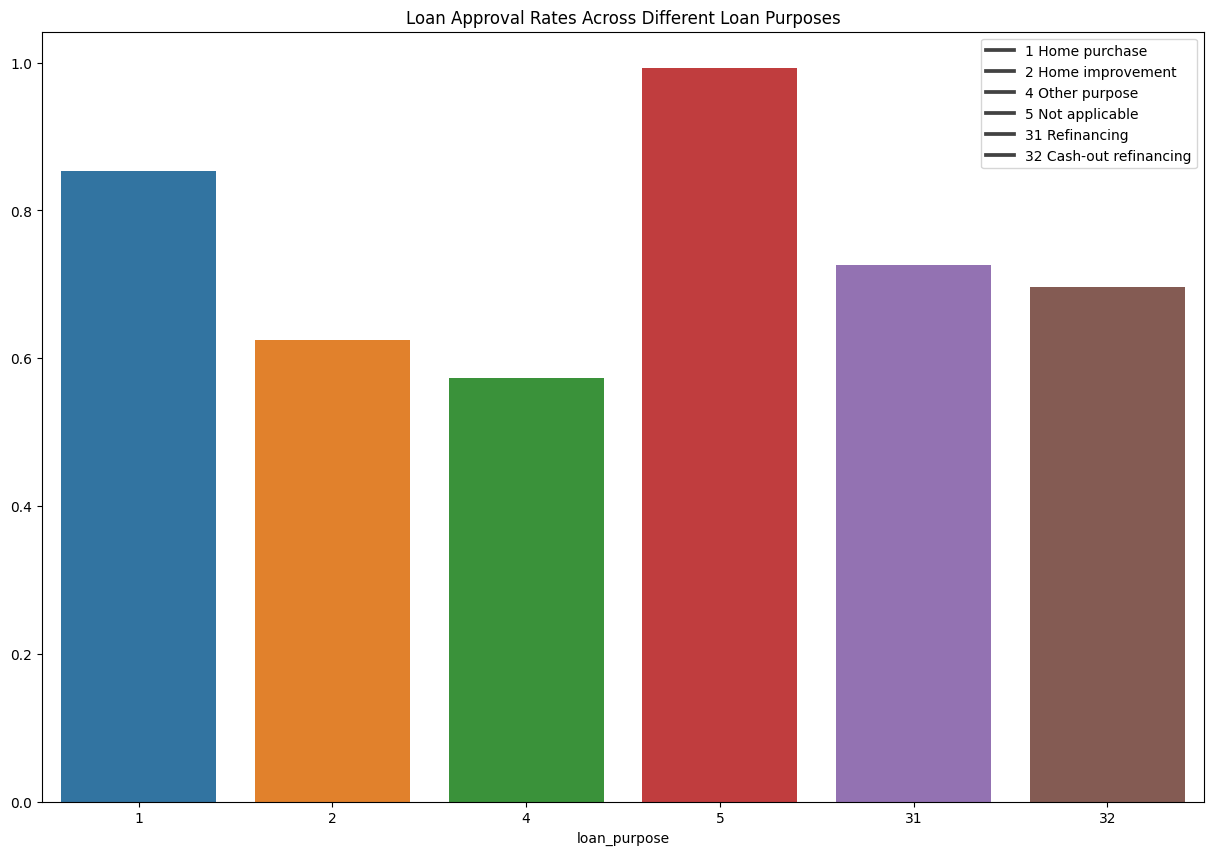

In [76]:
loanpurpose_rates = sampled_data.groupby('loan_purpose')['action_taken'].value_counts(normalize=True).loc[:,1]

plt.figure(figsize=(15,10))
sns.barplot(x=loanpurpose_rates.index, y=loanpurpose_rates.values)

labels = {
 1:  'Home purchase',
 2:  'Home improvement',
 31: 'Refinancing',
 32: 'Cash-out refinancing',
 4:  'Other purpose',
 5:  'Not applicable'
       }

# Create the legend
legend_labels = [f'{action} {labels[action]}' for action in loanpurpose_rates.index]
plt.legend(legend_labels, loc='upper right')
plt.title("Loan Approval Rates Across Different Loan Purposes")


# Show the plot
plt.show()


> **`Feature: hoepa status`**



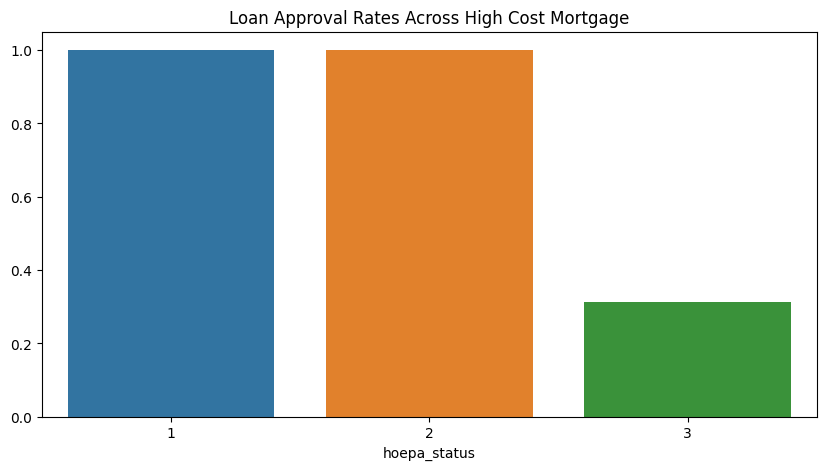

In [77]:
hoepa_rates = sampled_data.groupby('hoepa_status')['action_taken'].value_counts(normalize=True).loc[:,1]

plt.figure(figsize=(10,5))
sns.barplot(x=hoepa_rates.index, y=hoepa_rates.values)

plt.title("Loan Approval Rates Across High Cost Mortgage") #1-high cost #2 not hih cost #3- N/A
plt.show()

> **`Feature: Applicant Race`**

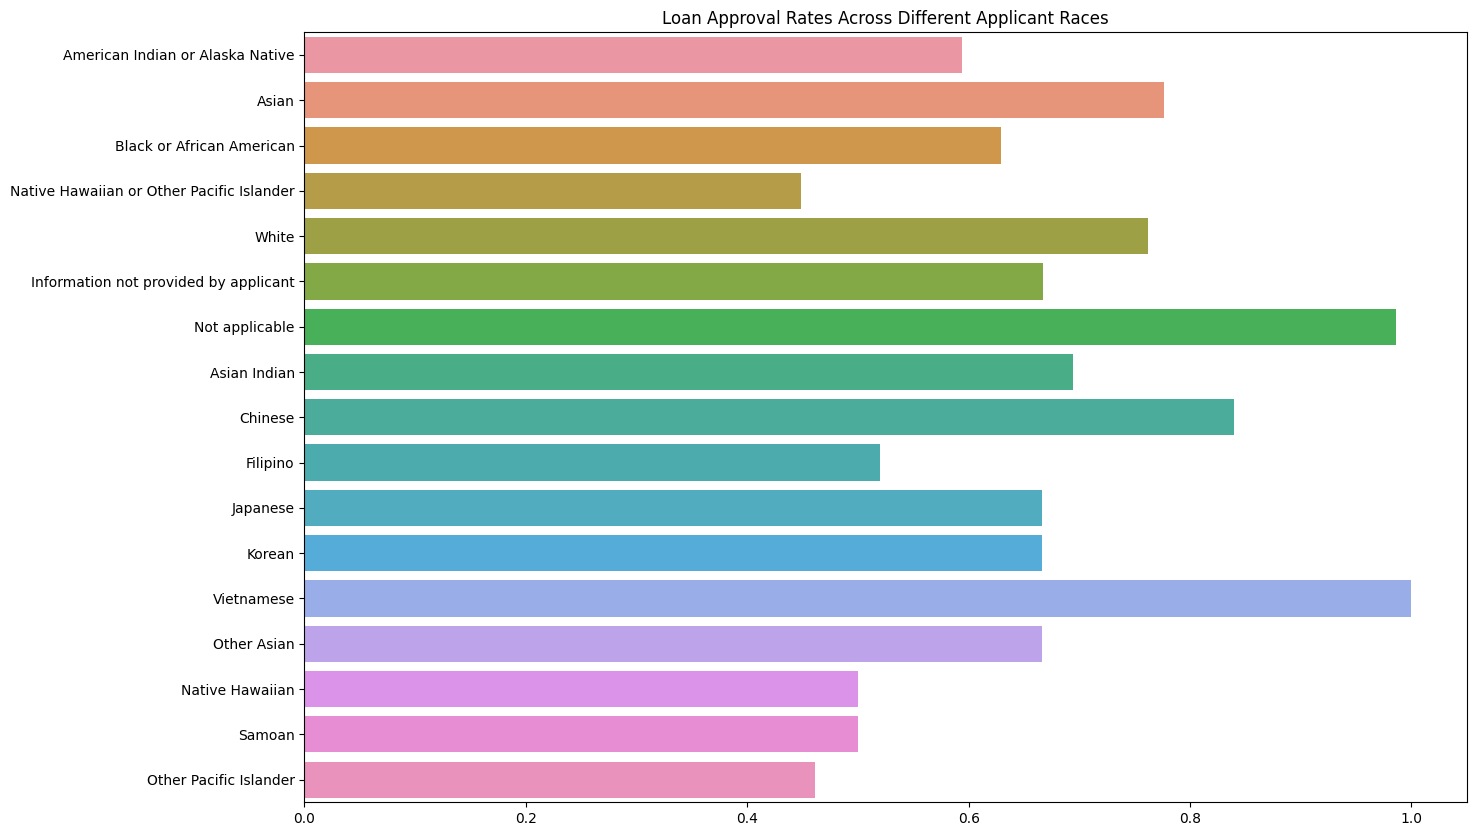

In [78]:

race_labels = {
    1: 'American Indian or Alaska Native',
    2: 'Asian',
    21: 'Asian Indian',
    22: 'Chinese',
    23: 'Filipino',
    24: 'Japanese',
    25: 'Korean',
    26: 'Vietnamese',
    27: 'Other Asian',
    3: 'Black or African American',
    4: 'Native Hawaiian or Other Pacific Islander',
    41: 'Native Hawaiian',
    42: 'Guamanian or Chamorro',
    43: 'Samoan',
    44: 'Other Pacific Islander',
    5: 'White',
    6: 'Information not provided by applicant',
    7: 'Not applicable'
}

# Group data and calculate loan approval rates by applicant race
race_rates = sampled_data.groupby('applicant_race_1')['action_taken'].value_counts(normalize=True).loc[:, 1]


plt.figure(figsize=(15, 10))
sns.barplot(x=race_rates.values, y=[race_labels[x] for x in race_rates.index], orient='h')



# Set the title
plt.title("Loan Approval Rates Across Different Applicant Races")

# Display the plot
plt.show()


# **3. Model Building**

### **3.1 Train Test Split**

In [79]:
#state code needs to be numeric for our analysis, not object
print(sampled_data['state_code'].unique())

['AZ' 'FL' 'IL' 'CO' 'TX' 'LA' 'CA' 'SC' 'NJ' 'DE' 'AL' 'NY' 'NC' 'TN'
 'WV' 'IA' 'GA' 'VA' 'IN' 'MO' 'WI' 'ID' 'MI' 'KY' 'NV' 'MN' 'UT' 'PA'
 'MA' 'WA' 'OK' 'AK' 'AR' 'NM' 'MS' 'KS' 'CT' 'OH' 'NH' 'OR' 'MD' 'SD'
 'NE' 'HI' 'PR' 'VT' 'ME' 'MT' 'DC' 'ND' 'WY' 'RI']


In [80]:
# convert state code into numeric with one hot encoding
one_hot_encoded_states = pd.get_dummies(sampled_data['state_code'], prefix='state', drop_first=True)


# Concatenate the one-hot encoded Df with sample data
sampled_data = pd.concat([sampled_data, one_hot_encoded_states], axis=1)


# Drop the original 'state_code' column (optional)
sampled_data=sampled_data.drop(columns=['state_code'])


In [81]:
# Check for missing values in each column before train test split
columns_with_missing = sampled_data.isna().any()

# Get the names of columns with missing values
columns_with_missing_names = columns_with_missing[columns_with_missing].index

# Print the names of columns with missing values
print(columns_with_missing_names)

#none good to move on

Index([], dtype='object')


In [82]:
# split out vaidation dataset for the end
Y=sampled_data['action_taken']
X=sampled_data.loc[:, sampled_data.columns != 'action_taken']
test_set=0.2
seed=123
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=test_set, random_state=seed)

In [83]:
print(sampled_data['action_taken'].value_counts())

1.0    19523
2.0     6141
Name: action_taken, dtype: int64


### **3.2 Comparing Supervised Learning Models and Algorithms**

Since I have imbalanced target variable, I might encounter some issues like:
**Model Bias**, favoring majority class and struggling to identify minority class outcomes effectively; **Reduced Sensitivity**, similarly, models can have reduced sensitivity to the minority class due to its smaller sample size.

To address those potential issues, I will try to use models that handle imbalanced data well for classification problems. For supervised learning, I will run multiple models and evaluate their performance on training set:

Models I will be using are:

- **Logistic Regression**

- **KNN**

- **Randome Forests**

- **Gradient Boosting**


In [84]:
models=[]

models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBM', GradientBoostingClassifier()))



#### **K-Fold Cross Validation & Algorithm Comparison**


In [85]:
# Define the number of folds for cross-validation
num_folds = 8

# Define the scoring metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'roc_auc']

# Create a list of models to evaluate
models = [
    ('Logistic Regression', LogisticRegression()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]



results = {}
metric_scores=[]
# Perform cross-validation for each model and each scoring metric
for scoring_metric in scoring_metrics:
    print(f"\nScoring Metric: {scoring_metric}\n")
    for name, model in models:
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring_metric)
        metric_scores.append(cv_results)
        results[scoring_metric]=metric_scores
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)



Scoring Metric: accuracy

Logistic Regression: 0.764843 (0.009715)
K-Nearest Neighbors: 0.772149 (0.009289)
Random Forest: 0.995032 (0.001468)
Gradient Boosting: 0.996883 (0.001445)

Scoring Metric: precision

Logistic Regression: 0.772514 (0.009586)
K-Nearest Neighbors: 0.816939 (0.009777)
Random Forest: 0.998203 (0.000986)
Gradient Boosting: 0.999421 (0.000403)

Scoring Metric: recall

Logistic Regression: 0.978703 (0.004139)
K-Nearest Neighbors: 0.902318 (0.006638)
Random Forest: 0.995254 (0.001287)
Gradient Boosting: 0.996546 (0.001714)

Scoring Metric: roc_auc

Logistic Regression: 0.680369 (0.008823)
K-Nearest Neighbors: 0.688017 (0.013725)
Random Forest: 0.999237 (0.000351)
Gradient Boosting: 0.999451 (0.000277)


Looking at all the evaluation metrics for 4 models, Gradient Boostings outperforms on each scoring metric.

- **Accuracy**, which measures the proportion of correct predictions out of the total predictions made by the mdoel is 0.997;

- **Precision**, which measures the proportion of true positive predictions out of the total positive predictions is 0.999.

- **Recall**, which measures the proportion of true positive predictions out of total actual positive samples is 0.997

- **ROC** curve, which plots True Positive Rates (recall) against False Positive Rates at various threshold levels, and ROC AUC which summarizes the curve's performance in a single value is 0.9995.

#### **GBM Tuning and Grid Search**

Since GBM outperformed all 3 other models, I will use it to build the final model for supervised learning and evaluate the performance.

In [86]:
# Grid Search: GradientBoosting Tuning
n_estimators = [20,200]
max_depth= [3,8]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
# Define the scoring metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'roc_auc']

best_model=None
best_score=0.0
best_scoring_metric = ""

for scoring_metric in scoring_metrics:
  print(f"\nScoring Metrics: {scoring_metric}\n")

model = GradientBoostingClassifier()

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=47)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring_metric, cv=kfold)

grid_result = grid.fit(X_train, Y_train)

#Print Results

print(f"Best Score: {grid_result.best_score_}")
print(f"Best Parameters: {grid_result.best_params_}")

# Update the best model and best score if a higher score is achieved
if grid_result.best_score_ > best_score:
   best_model = grid_result.best_estimator_
   best_score = grid_result.best_score_
   best_scoring_metric = scoring_metric

print(f"\nChosen Scoring Metric: {best_scoring_metric}")


Scoring Metrics: accuracy


Scoring Metrics: precision


Scoring Metrics: recall


Scoring Metrics: roc_auc

Best Score: 0.9993595793151554
Best Parameters: {'max_depth': 3, 'n_estimators': 200}

Chosen Scoring Metric: roc_auc


#### **Finalise the Model & Evaluate it on Test Set**

I will finalize GBM model with the best parameters found during tuning step above.

In [87]:
# prepare model
model = GradientBoostingClassifier(max_depth= 3, n_estimators= 200)
model.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=200)

In [88]:
# estimate accuracy on validation set
predictions = model.predict(X_test)
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.9982466393921683
[[3917    7]
 [   2 1207]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      3924
         2.0       0.99      1.00      1.00      1209

    accuracy                           1.00      5133
   macro avg       1.00      1.00      1.00      5133
weighted avg       1.00      1.00      1.00      5133



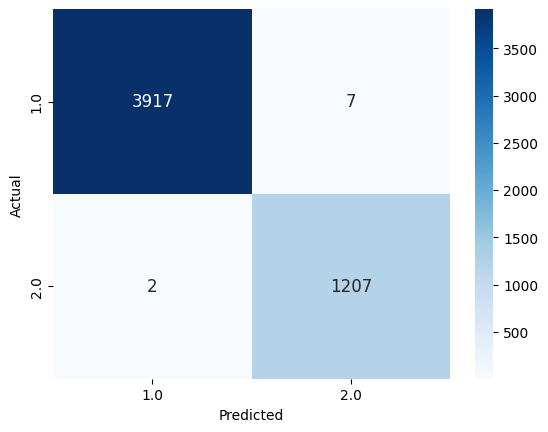

In [89]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, predictions), columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

df_cm_rounded = df_cm.round(3)

sns.heatmap(df_cm_rounded, cmap="Blues", annot=True,annot_kws={"size": 12}, fmt='g')# font sizes

plt.show()

#### **Model Intuition & Variable Importance**

[7.41934580e-04 1.81581211e-05 0.00000000e+00 3.03061132e-05
 3.45748532e-07 1.32451673e-03 2.19507338e-04 3.92155908e-04
 3.59830470e-01 6.04749046e-01 4.06310176e-03 7.36466845e-06
 3.55164382e-06 9.03333214e-05 2.33772049e-02 2.22548758e-04
 1.85901034e-03 1.46624672e-05 1.77913083e-05 9.94022000e-06
 2.17543209e-03 2.37925438e-05 7.53315566e-05 2.09991065e-04
 1.11882310e-04 1.47223325e-05 0.00000000e+00 5.29673257e-06
 1.83549947e-07 4.61989374e-05 3.89878976e-05 5.41320624e-05
 0.00000000e+00 0.00000000e+00 3.02035196e-07 3.42362520e-05
 0.00000000e+00 5.71807301e-06 0.00000000e+00 0.00000000e+00
 3.84408322e-07 1.40787920e-05 1.97148058e-05 1.94472339e-05
 2.80737416e-06 0.00000000e+00 9.85599213e-06 0.00000000e+00
 5.98299584e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.80809273e-05 0.00000000e+00 3.70657762e-06 7.23188839e-06
 7.89808761e-06 1.33743772e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.74159999e-07 0.00000000e+00
 9.01896141e-05 0.000000

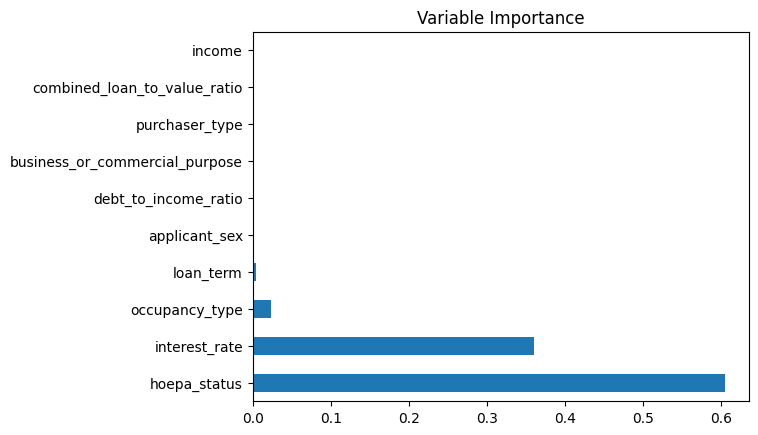

In [90]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Variable Importance')
plt.show()

Based on the GBM model, the most important variables in loan eligibility prediction (whether approved or denied) are:

* hoepa status, which indicates whether the covered loan is a high-cost mortgage or not.
* interest rate (surprisingly there was not much correlation between action_taken and interest rate when we did data exploration above).
* occupancy type, which is occupancy type of a dwelling (1 - Principal residence; 2 - Second residence; 3 - Investment property)
* loan term.

### **3.3 Comparing Unsupervised Learning Models and Algorithms**

The GBM model demonstrated great performance for my dataset. However, I will explore unsupervised learning model to further evaluate the performance and potentially discover interesting insights.

For the unsupervised learning model, I will be utilizing the following algorithms:


* **K-Means**


#### **K-Means**


In [91]:
#standardize X
scaler=StandardScaler()
X_std=scaler.fit_transform(X)

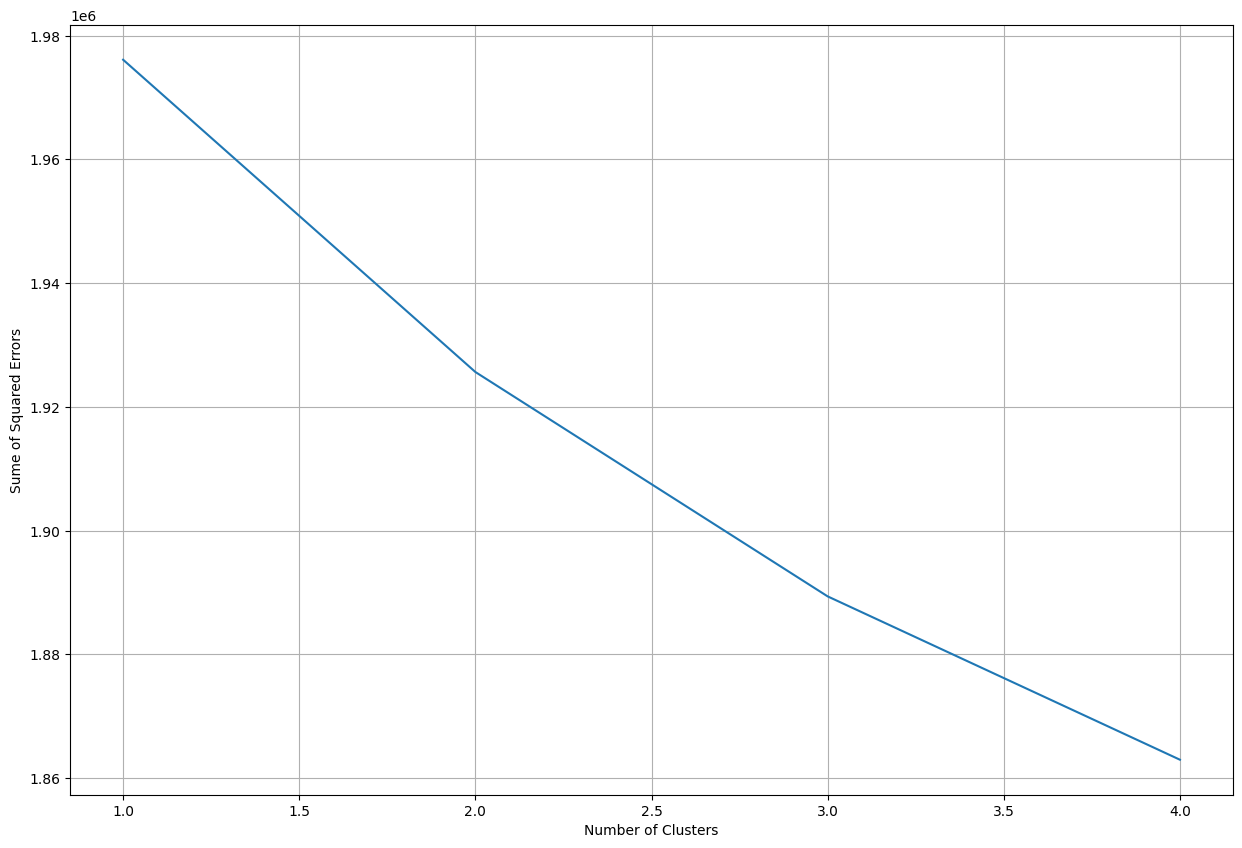

In [92]:
# find the optimal number of clusters

#Elbow method

SSE=[]

max_loops=5
for k in range(1, max_loops):
    k_means=KMeans(n_clusters=k)
    k_means.fit(X_std)
    SSE.append(k_means.inertia_)

#visualize
fig=plt.figure(figsize=(15,10))
plt.plot(range(1, max_loops), SSE)
plt.xlabel("Number of Clusters")
plt.ylabel("Sume of Squared Errors")
plt.grid(True)

plt.show()

We already know that there are 2 outcomes in the action taken (accept or reject), but technically we have third category I eliminated, other (which could be withdrawn applications, preapproval approved but not accepted)

I will try K means with 2 & 3 clusters.

In [93]:
from sklearn import metrics

nclust = [2, 3]
sil_scores = []
ari_scores= []
true_labels=sampled_data['action_taken']




for cluster in nclust:
    k_means = KMeans(n_clusters=cluster, random_state=47)
    k_means.fit(X_std)
    labels = k_means.predict(X_std)
    sil_score = metrics.silhouette_score(X_std, labels, metric='euclidean')
    sil_scores.append(sil_score)
    ari=metrics.adjusted_rand_score(true_labels, labels)
    ari_scores.append(ari)

print("Silhouette Scores for k=2 & k=3 are:", sil_scores)

print("Adjusted Rand Index or k=2 & k=3 are:", ari_scores)



Silhouette Scores for k=2 & k=3 are: [0.11409178130655127, 0.06424570420151826]
Adjusted Rand Index or k=2 & k=3 are: [-0.013149830210326252, -0.03220968954710578]


#### **K-Means Intuition**

K-Means didnot perform well at all with my dataset. Since Clustering Algorithm, like K-Means, is an unsupervised learning method, it does not inherently have true labels during the training process.

My dataset is more suitable for supervised learning models and all supervised models I tried above outperformed K-means.

Still I would like to see the clustering intuition behind the K-means model with K=2 clusters

In [94]:
kmeans_2=KMeans(n_clusters=2, random_state=123)
kmeans_2.fit(X_std)

labels=kmeans_2.labels_
kmeans_2_pred=kmeans_2.predict(X_std)

In [95]:
cluster_output= pd.concat([pd.DataFrame(sampled_data), pd.DataFrame(labels, columns = ['cluster'])],axis = 1)
output=cluster_output.groupby('cluster').mean()
output

,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,business_or_commercial_purpose,loan_amount,combined_loan_to_value_ratio,interest_rate,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
cluster,,,,,,,,,,,,,,,,,,,,,
0.0,1.239623,5.848428,1.979245,1.258491,11.79434,1.191824,1.952201,246540.880503,75.966663,4.71796,...,0.003145,0.029560,0.082390,0.008805,0.030189,0.000629,0.031447,0.013836,0.004403,0.000000
1.0,1.232436,5.571239,1.975238,1.268596,10.95760,1.193869,1.953670,247942.419181,76.594594,4.69168,...,0.002899,0.025499,0.084259,0.013413,0.027857,0.001818,0.028004,0.016164,0.003488,0.001425


> **Visualizeing Clustering for Numeric Variables**

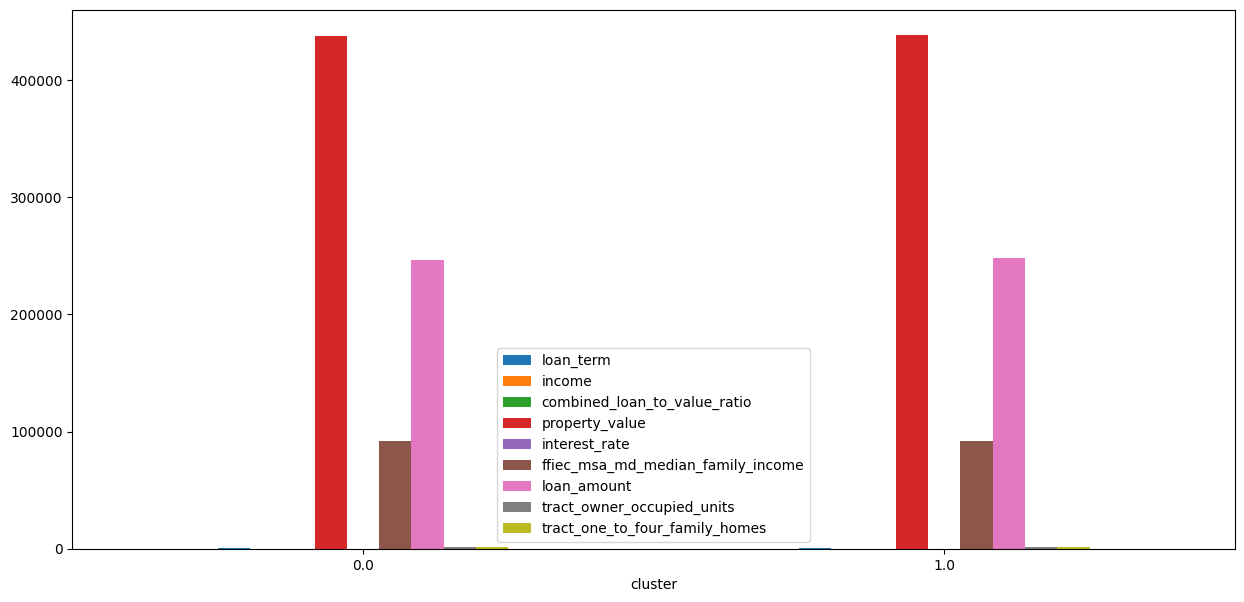

In [97]:
output[['loan_term', 'income', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'ffiec_msa_md_median_family_income', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']].plot.bar(rot=0, figsize=(15,7));



> **Visualizeing Clustering for Categorical Variables**

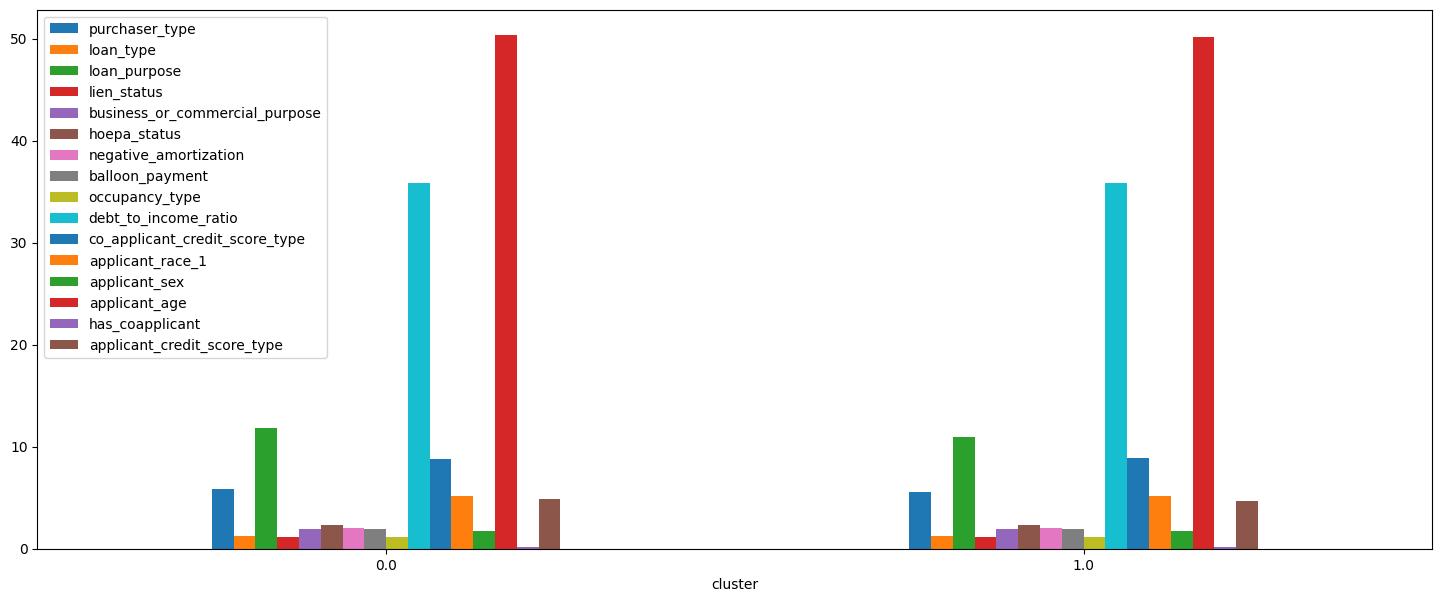

In [98]:
output[[
    'purchaser_type', 'loan_type', 'loan_purpose', 'lien_status', 'business_or_commercial_purpose',
    'hoepa_status', 'negative_amortization', 'balloon_payment', 'occupancy_type', 'debt_to_income_ratio',
    'co_applicant_credit_score_type', 'applicant_race_1', 'applicant_sex', 'applicant_age', 'has_coapplicant', 'applicant_credit_score_type'
]].plot.bar(rot=0, figsize=(18,7));

The weights of the variables among the two clusters show minimal differences. As previously determined, unsupervised learning may not be the most suitable algorithm for analyzing my data.

# **4. Conclusion & Final Notes**


I have developed an XGBoost model to analyze the 2022 HDMA LAR dataset and predict loan eligibility based on the provided loan data. The model has produced robust results, achieving over 99% scores on all evaluation metrics, including precision, accuracy, and recall.

However, there are several considerations to keep in mind:

Imbalanced Target Variable: The target variable, "action taken," exhibits imbalanced data with the majority of outcomes being approved loans. This class imbalance may potentially impact the model's performance, despite the robustness of XGBoost. To mitigate this issue, I have utilized techniques provided by XGBoost, such as assigning different weights to different classes in the loss function and employing sampling techniques to balance the class distribution during training.

Sample Size: For computational reasons, I have used a random sample of 30,000 observations from the dataset. While this sample has consistently produced reliable outcomes with the XGBoost model, it is important to note that using larger samples and evaluating the model on different datasets would be beneficial for a more comprehensive evaluation.

Evaluation Scores: It is essential to be cautious when observing very high evaluation scores on both the training and test sets. While I have taken steps to mitigate potential issues, such as splitting the data into training and test sets and utilizing cross-validation techniques, it is advisable to further investigate the model's performance. Additional steps, such as consulting domain experts and conducting further experiments or tests, can provide valuable insights.

In addition, I have examined feature importance to understand which variables contribute to loan approval predictions. The results align with common sense and existing finance literature. Nonetheless, engaging domain experts and conducting additional experiments can provide further validation and insights into the model's performance.
